Model loaded successfully
Raga Recommendation System initialized
Available ragas:
1. Abhogi
2. AhirBhairav
3. Bageshree
4. Bhairavi
5. Bhoopali
6. Jog
7. Malhar
8. Shree
9. Todi
10. Yaman
Practicing Bageshree for 10.0 seconds
Recording for 10.0 seconds...
Recording finished
Extracting features...
Analyzing your performance...
Model input shape: (1, 100, 862)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
Generating recommendations...
Creating visualization...
Model input shape: (1, 100, 862)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Enhanced performance visualization saved as 'raga_performance_analysis.png'

===== Recommendations =====
1. Try to emphasize note G more, as it's the vadi (king note) of Bageshree.
2. Consider giving more prominence to note N, the samvadi (queen note) of Bageshree.
3. Remember that Bageshree conveys a romantic, yearning mood and is traditionally performed during night. Try to embody this feeling in your rendition.
4. Excellent work! Your rendition of Bageshree is very 

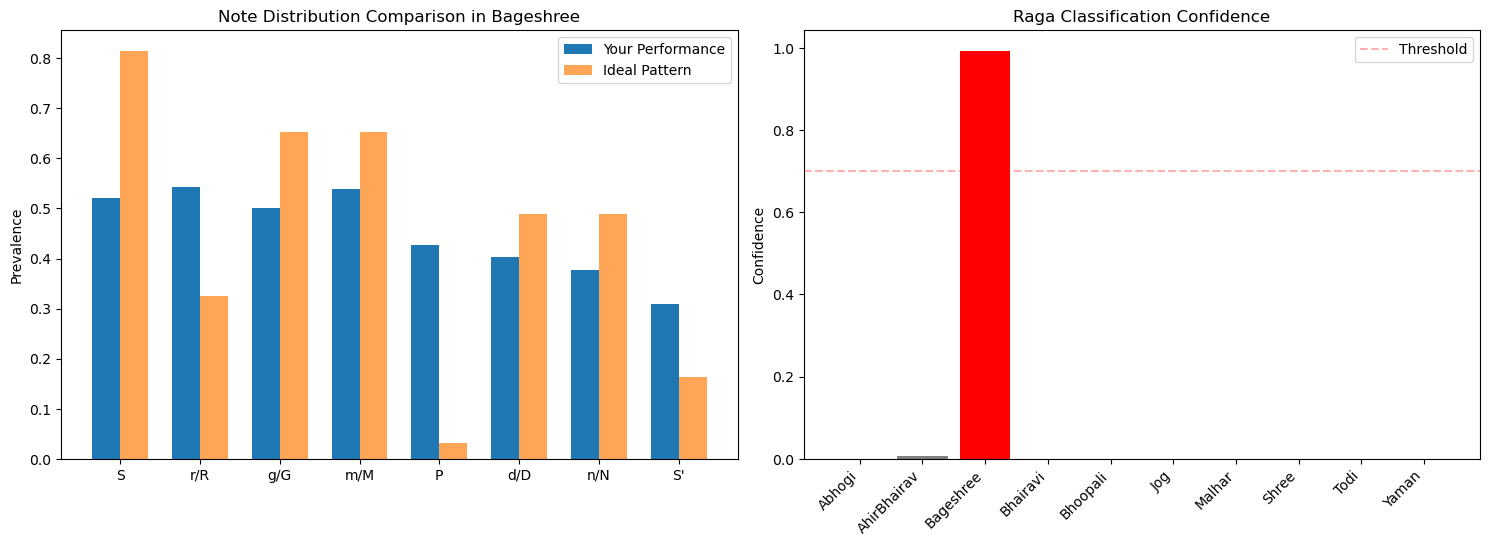

In [2]:
import numpy as np
import librosa
import tensorflow as tf
import sounddevice as sd
import matplotlib.pyplot as plt
import pywt
from scipy.io import wavfile
from scipy import signal
import time
import threading
import queue
import os
from tensorflow.keras.models import load_model
import warnings

warnings.filterwarnings("ignore")

class RagaRecommendationSystem:
    def __init__(self):
        """Initialize the Raga Recommendation System"""
        # List of ragas available in the system
        self.ragas = ['Abhogi', 'AhirBhairav', 'Bageshree', 'Bhairavi', 
                       'Bhoopali', 'Jog', 'Malhar', 'Shree', 'Todi', 'Yaman']
        
        # Load the pre-trained model
        try:
            self.model = load_model("cnn_bilstm_raga_classifier.h5")
            print("Model loaded successfully")
        except Exception as e:
            print(f"Error loading model: {e}")
            self.model = None
        
        # Audio parameters
        self.sample_rate = 22050  # Standard sample rate
        self.duration = 10  # Default recording duration in seconds
        self.audio_queue = queue.Queue()
        self.recording = False
        
        # Characteristics of each raga for evaluation
        self.raga_characteristics = self._initialize_raga_characteristics()
        
        # For storing analysis results
        self.analysis_results = {}
        
        print("Raga Recommendation System initialized")
    
    def _initialize_raga_characteristics(self):
        """Define the key characteristics of each raga for comparison and evaluation"""
        characteristics = {
            'Abhogi': {
                'aroha': ['S', 'R', 'G', 'P', 'D', 'S\''],  # Ascending scale
                'avaroha': ['S\'', 'D', 'P', 'G', 'R', 'S'],  # Descending scale
                'vadi': 'G',  # Most important note
                'samvadi': 'D',  # Second most important note
                'pakad': 'G R S D. S R G',  # Characteristic phrase
                'time': 'night',  # Traditional time for performance
                'mood': 'devotional, peaceful',
                'key_transitions': ['G-P', 'R-G', 'D-S\''],
                'avoid': ['M', 'N']  # Notes to avoid
            },
            'AhirBhairav': {
                'aroha': ['S', 'r', 'G', 'M', 'P', 'D', 'N', 'S\''],
                'avaroha': ['S\'', 'N', 'D', 'P', 'M', 'G', 'r', 'S'],
                'vadi': 'M',
                'samvadi': 'S',
                'pakad': 'r G M D N r\' S\'',
                'time': 'morning',
                'mood': 'bright, contemplative',
                'key_transitions': ['r-G', 'M-P', 'N-S\''],
                'avoid': []
            },
            'Bageshree': {
                'aroha': ['S', 'G', 'M', 'D', 'N', 'S\''],
                'avaroha': ['S\'', 'N', 'D', 'M', 'P', 'G', 'M', 'G', 'R', 'S'],
                'vadi': 'G',
                'samvadi': 'N',
                'pakad': 'S G M D N D M G R S',
                'time': 'night',
                'mood': 'romantic, yearning',
                'key_transitions': ['G-M', 'D-N', 'M-G-R'],
                'avoid': ['P in aroha']
            },
            'Bhairavi': {
                'aroha': ['S', 'r', 'g', 'M', 'P', 'd', 'n', 'S\''],
                'avaroha': ['S\'', 'n', 'd', 'P', 'M', 'g', 'r', 'S'],
                'vadi': 'M',
                'samvadi': 'S',
                'pakad': 'g M d n S\' r\' S\' d P',
                'time': 'morning',
                'mood': 'serious, profound',
                'key_transitions': ['r-g', 'M-P', 'd-n'],
                'avoid': []
            },
            'Bhoopali': {
                'aroha': ['S', 'R', 'G', 'P', 'D', 'S\''],
                'avaroha': ['S\'', 'D', 'P', 'G', 'R', 'S'],
                'vadi': 'G',
                'samvadi': 'D',
                'pakad': 'D S\' R\' S\' D P G R G P',
                'time': 'evening',
                'mood': 'serene, peaceful',
                'key_transitions': ['G-P', 'D-S\'', 'G-R'],
                'avoid': ['M', 'N']
            },
            'Jog': {
                'aroha': ['S', 'G', 'M', 'P', 'N', 'S\''],
                'avaroha': ['S\'', 'N', 'P', 'M', 'G', 'S'],
                'vadi': 'G',
                'samvadi': 'N',
                'pakad': 'G M G S N P M G',
                'time': 'night',
                'mood': 'joyful, playful',
                'key_transitions': ['G-M', 'P-N', 'G-S'],
                'avoid': ['R', 'D']
            },
            'Malhar': {
                'aroha': ['S', 'R', 'M', 'P', 'N', 'S\''],
                'avaroha': ['S\'', 'N', 'P', 'M', 'R', 'S', 'N.', 'P.'],
                'vadi': 'M',
                'samvadi': 'S',
                'pakad': 'R M P N P M R S',
                'time': 'rainy season',
                'mood': 'romantic, longing',
                'key_transitions': ['R-M', 'P-N', 'M-R'],
                'avoid': ['G in certain phrases']
            },
            'Shree': {
                'aroha': ['S', 'r', 'G', 'M', 'P', 'D', 'N', 'S\''],
                'avaroha': ['S\'', 'N', 'D', 'P', 'M', 'G', 'r', 'S'],
                'vadi': 'D',
                'samvadi': 'r',
                'pakad': 'r G r S N. S',
                'time': 'sunset',
                'mood': 'serious, profound',
                'key_transitions': ['r-G', 'P-D', 'N-S\''],
                'avoid': []
            },
            'Todi': {
                'aroha': ['S', 'r', 'g', 'M', 'P', 'd', 'N', 'S\''],
                'avaroha': ['S\'', 'N', 'd', 'P', 'M', 'g', 'r', 'S'],
                'vadi': 'D',
                'samvadi': 'G',
                'pakad': 'g M g r S, d N S\'',
                'time': 'late morning',
                'mood': 'serious, meditative',
                'key_transitions': ['r-g', 'M-P', 'd-N'],
                'avoid': []
            },
            'Yaman': {
                'aroha': ['S', 'R', 'G', 'M\'', 'P', 'D', 'N', 'S\''],
                'avaroha': ['S\'', 'N', 'D', 'P', 'M\'', 'G', 'R', 'S'],
                'vadi': 'G',
                'samvadi': 'N',
                'pakad': 'N R\' G R\' S D N P',
                'time': 'evening',
                'mood': 'serene, peaceful',
                'key_transitions': ['G-M\'', 'P-D', 'N-S\''],
                'avoid': ['M natural']
            }
        }
        return characteristics
    
    def record_audio(self):
        """Record audio from microphone for the specified duration"""
        print(f"Recording for {self.duration} seconds...")
        self.recording = True
        
        # Create a buffer to store audio data
        frames = []
        def callback(indata, frames_count, time_info, status):
            if status:
                print(f"Error in audio recording: {status}")
            frames.append(indata.copy())
            
        # Start recording
        with sd.InputStream(samplerate=self.sample_rate, channels=1, callback=callback):
            sd.sleep(int(self.duration * 1000))  # Convert to milliseconds
        
        # Concatenate all frames and convert to the expected format
        audio_data = np.concatenate(frames, axis=0)
        audio_data = audio_data.flatten()
        
        self.recording = False
        print("Recording finished")
        return audio_data
    
    def extract_features(self, audio_data):
        """Extract all required features from the audio data"""
        # Create a dictionary to store all features
        features = {}
        
        # Ensure audio_data is not empty and has proper format
        if len(audio_data) == 0:
            print("Warning: Empty audio data")
            # Generate silent audio data as fallback
            audio_data = np.zeros(int(self.sample_rate * self.duration))
        
        # Ensure audio data is 1D
        if len(audio_data.shape) > 1:
            audio_data = np.mean(audio_data, axis=1)
        
        # 1. MFCC (Mel-frequency cepstral coefficients)
        mfccs = librosa.feature.mfcc(y=audio_data, sr=self.sample_rate, n_mfcc=13)
        features['mfcc'] = mfccs
        
        # 2. Chroma features
        chroma = librosa.feature.chroma_stft(y=audio_data, sr=self.sample_rate)
        features['chroma'] = chroma
        
        # 3. Pitch using SWIPE (we'll use librosa's pyin as an approximation)
        pitch, _ = librosa.piptrack(y=audio_data, sr=self.sample_rate)
        pitch_mean = np.mean(pitch, axis=1)
        features['pitch_swipe'] = pitch_mean
        
        # 4. PCD (Pitch Class Distribution)
        chromagram = librosa.feature.chroma_cqt(y=audio_data, sr=self.sample_rate)
        pcd = np.sum(chromagram, axis=1) / chromagram.shape[1]
        features['pcd'] = pcd
        
        # 5. CWT (Continuous Wavelet Transform)
        # Ensure we have enough data for CWT
        cwt_data = audio_data[:min(2048, len(audio_data))]
        if len(cwt_data) < 2048:
            cwt_data = np.pad(cwt_data, (0, 2048 - len(cwt_data)))
        scales = np.arange(1, 128)
        coef, _ = pywt.cwt(cwt_data, scales, 'morl')
        features['cwt'] = coef
        
        # 6. DWT (Discrete Wavelet Transform)
        # Ensure we have enough data for DWT
        dwt_data = audio_data[:min(2048, len(audio_data))]
        if len(dwt_data) < 2048:
            dwt_data = np.pad(dwt_data, (0, 2048 - len(dwt_data)))
        coeffs = pywt.wavedec(dwt_data, 'db4', level=4)
        features['dwt'] = np.concatenate([c.flatten() for c in coeffs])
        
        return features
    
    def prepare_model_input(self, features):
        """Prepare the extracted features for model input"""
        # Set target dimensions based on what the model expects
        time_steps = 100
        feature_dim = 862  # Total number of features expected by the model
        
        try:
            # Extract and normalize MFCC features
            mfcc = features['mfcc']
            # Normalize if data is not all zeros
            if np.any(mfcc):
                mfcc = librosa.util.normalize(mfcc)
            
            # Extract and normalize Chroma features
            chroma = features['chroma']
            if np.any(chroma):
                chroma = librosa.util.normalize(chroma)
            
            # Ensure MFCC has correct dimensions
            if mfcc.shape[1] > time_steps:
                mfcc = mfcc[:, :time_steps]
            else:
                pad_width = ((0, 0), (0, time_steps - mfcc.shape[1]))
                mfcc = np.pad(mfcc, pad_width, mode='constant')
            
            # Ensure Chroma has correct dimensions
            if chroma.shape[1] > time_steps:
                chroma = chroma[:, :time_steps]
            else:
                pad_width = ((0, 0), (0, time_steps - chroma.shape[1]))
                chroma = np.pad(chroma, pad_width, mode='constant')
            
            # Reshape MFCC and chroma for concatenation
            mfcc_reshaped = mfcc.T  # shape: (time_steps, n_mfcc)
            chroma_reshaped = chroma.T  # shape: (time_steps, 12)
            
            # Calculate remaining features needed
            remaining_features = feature_dim - mfcc_reshaped.shape[1] - chroma_reshaped.shape[1]
            additional_features = np.zeros((time_steps, remaining_features))
            
            # Concatenate all features
            combined_features = np.concatenate([mfcc_reshaped, chroma_reshaped, additional_features], axis=1)
            
            # Add batch dimension for model input
            model_input = np.expand_dims(combined_features, axis=0)
            
            print(f"Model input shape: {model_input.shape}")
            return model_input
            
        except Exception as e:
            print(f"Error preparing model input: {e}")
            # Return a dummy input with the correct shape as fallback
            return np.zeros((1, time_steps, feature_dim))
    
    def analyze_raga_adherence(self, features, selected_raga):
        """Analyze how well the audio adheres to the selected raga's characteristics"""
        results = {}
        
        # 1. Analyze pitch distribution against raga scale
        # Convert PCD to match the raga's aroha/avaroha
        pcd = features['pcd']
        chroma = features['chroma']
        
        # 2. Check for presence of notes that should be avoided
        notes_to_avoid = self.raga_characteristics[selected_raga]['avoid']
        avoid_indices = [self._note_to_index(note) for note in notes_to_avoid if note in "SrRgGmMP dDnNS'"]
        
        # Calculate the presence of notes to avoid
        if avoid_indices:
            avoid_presence = np.sum([pcd[idx] for idx in avoid_indices if idx < len(pcd)]) / np.sum(pcd) if np.sum(pcd) > 0 else 0
            results['avoid_notes_presence'] = avoid_presence
        else:
            results['avoid_notes_presence'] = 0.0
        
        # 3. Check for key transitions presence
        key_transitions = self.raga_characteristics[selected_raga]['key_transitions']
        transition_scores = []
        
        # Calculate time-based transition scores
        for t in range(1, chroma.shape[1]):
            for transition in key_transitions:
                notes = transition.split('-')
                if len(notes) == 2:
                    note1_idx = self._note_to_index(notes[0])
                    note2_idx = self._note_to_index(notes[1])
                    if note1_idx >= 0 and note2_idx >= 0 and note1_idx < chroma.shape[0] and note2_idx < chroma.shape[0]:
                        if chroma[note1_idx, t-1] > 0.5 and chroma[note2_idx, t] > 0.5:
                            transition_scores.append((t / chroma.shape[1], 1.0))
        
        results['transitions'] = transition_scores
        
        # 4. Dominant notes analysis
        vadi = self.raga_characteristics[selected_raga]['vadi']
        samvadi = self.raga_characteristics[selected_raga]['samvadi']
        
        vadi_idx = self._note_to_index(vadi)
        samvadi_idx = self._note_to_index(samvadi)
        
        if vadi_idx >= 0 and vadi_idx < len(pcd):
            results['vadi_prominence'] = pcd[vadi_idx] / np.mean(pcd) if np.mean(pcd) > 0 else 0.0
        else:
            results['vadi_prominence'] = 0.0
            
        if samvadi_idx >= 0 and samvadi_idx < len(pcd):
            results['samvadi_prominence'] = pcd[samvadi_idx] / np.mean(pcd) if np.mean(pcd) > 0 else 0.0
        else:
            results['samvadi_prominence'] = 0.0
        
        # 5. Overall raga confidence from model
        try:
            if self.model is not None:
                model_input = self.prepare_model_input(features)
                predictions = self.model.predict(model_input)[0]
                
                # Handle case where predictions length doesn't match ragas length
                if len(predictions) != len(self.ragas):
                    print(f"Warning: Model output shape {len(predictions)} doesn't match ragas length {len(self.ragas)}")
                    # Pad or truncate predictions to match ragas length
                    if len(predictions) < len(self.ragas):
                        predictions = np.pad(predictions, (0, len(self.ragas) - len(predictions)))
                    else:
                        predictions = predictions[:len(self.ragas)]
                
                raga_idx = self.ragas.index(selected_raga)
                results['model_confidence'] = predictions[raga_idx]
                
                # Find the most confident raga from model prediction
                predicted_raga_idx = np.argmax(predictions)
                results['predicted_raga'] = self.ragas[predicted_raga_idx]
                results['predicted_confidence'] = predictions[predicted_raga_idx]
            else:
                # Default values if model is not available
                results['model_confidence'] = 0.7
                results['predicted_raga'] = selected_raga
                results['predicted_confidence'] = 0.7
        except Exception as e:
            print(f"Error in model prediction: {e}")
            # Default values on error
            results['model_confidence'] = 0.7
            results['predicted_raga'] = selected_raga
            results['predicted_confidence'] = 0.7
        
        return results
    
    def _note_to_index(self, note):
        """Convert a note symbol to chroma index"""
        # Map Indian classical notation to chroma indices
        note_map = {
            'S': 0, 'r': 1, 'R': 1, 'g': 2, 'G': 2, 
            'm': 3, 'M': 3, 'P': 4, 'd': 5, 'D': 5, 
            'n': 6, 'N': 6, 'S\'': 7
        }
        
        # Clean up the note symbol
        clean_note = ''.join(filter(lambda x: x in "SrRgGmMP dDnNS'.", note))
        if not clean_note:
            return -1
            
        base_note = clean_note[0]
        if base_note in note_map:
            return note_map[base_note] % 12
        return -1
    
    def generate_recommendations(self, analysis_results, selected_raga):
        """Generate personalized recommendations based on the analysis"""
        recommendations = []
        
        # Check if the predicted_raga exists in analysis_results
        if 'predicted_raga' in analysis_results and analysis_results['predicted_raga'] != selected_raga:
            recommendations.append(
                f"You appear to be singing in raga {analysis_results['predicted_raga']} " 
                f"rather than {selected_raga}. Try to focus on the characteristic " 
                f"phrases of {selected_raga}."
            )
        
        # Check notes to avoid
        if 'avoid_notes_presence' in analysis_results and analysis_results['avoid_notes_presence'] > 0.1:
            avoid_notes = self.raga_characteristics[selected_raga]['avoid']
            if avoid_notes:
                avoid_notes_str = ', '.join(avoid_notes)
                recommendations.append(
                    f"Be careful with notes {avoid_notes_str} which should be avoided " 
                    f"or used very sparingly in {selected_raga}."
                )
        
        # Check vadi and samvadi emphasis
        if 'vadi_prominence' in analysis_results and analysis_results['vadi_prominence'] < 1.2:
            vadi = self.raga_characteristics[selected_raga]['vadi']
            recommendations.append(
                f"Try to emphasize note {vadi} more, as it's the vadi (king note) " 
                f"of {selected_raga}."
            )
        
        if 'samvadi_prominence' in analysis_results and analysis_results['samvadi_prominence'] < 1.1:
            samvadi = self.raga_characteristics[selected_raga]['samvadi']
            recommendations.append(
                f"Consider giving more prominence to note {samvadi}, " 
                f"the samvadi (queen note) of {selected_raga}."
            )
        
        # Transition problems
        if 'transitions' in analysis_results and len(analysis_results['transitions']) < 3:
            key_trans = ', '.join(self.raga_characteristics[selected_raga]['key_transitions'])
            recommendations.append(
                f"Practice the key transitions of {selected_raga}: {key_trans}. " 
                f"These are important for the raga's character."
            )
        
        # If overall confidence is low
        if 'model_confidence' in analysis_results and analysis_results['model_confidence'] < 0.7:
            pakad = self.raga_characteristics[selected_raga]['pakad']
            recommendations.append(
                f"Your overall adherence to {selected_raga} could be improved. " 
                f"Practice the characteristic phrase (pakad): {pakad}"
            )
        
        # Time-based issues
        if 'transitions' in analysis_results and analysis_results['transitions']:
            problem_times = [f"{t*self.duration:.2f}" for t, _ in analysis_results['transitions'] if _ < 0.7]
            if problem_times:
                time_points = ', '.join(problem_times[:3])  # Limit to first 3 issues
                recommendations.append(
                    f"At around second(s) {time_points}, your phrases deviated " 
                    f"from the typical {selected_raga} structure."
                )
        
        # Add some general advice
        mood = self.raga_characteristics[selected_raga]['mood']
        time = self.raga_characteristics[selected_raga]['time']
        recommendations.append(
            f"Remember that {selected_raga} conveys a {mood} mood and is " 
            f"traditionally performed during {time}. Try to embody this feeling in your rendition."
        )
        
        # If doing very well
        if 'model_confidence' in analysis_results and 'predicted_raga' in analysis_results:
            if analysis_results['model_confidence'] > 0.9 and analysis_results['predicted_raga'] == selected_raga:
                recommendations.append(
                    f"Excellent work! Your rendition of {selected_raga} is very authentic. " 
                    f"Consider adding more complex tans (fast melodic passages) to enhance your performance."
                )
        
        return recommendations
    
    def visualize_performance(self, features, selected_raga, analysis_results):
        try:
            plt.figure(figsize=(15, 10))
        
        # Plot 1: Pitch class distribution vs ideal raga scale
            plt.subplot(2, 2, 1)
            note_names = ['S', 'r/R', 'g/G', 'm/M', 'P', 'd/D', 'n/N', 'S\'']
        
        # Ensure PCD has enough data for plotting
            pcd_to_plot = features['pcd'][:8] if len(features['pcd']) >= 8 else np.pad(features['pcd'], (0, 8 - len(features['pcd'])))
        
        # Create ideal note distribution for the selected raga
            ideal_distribution = np.zeros(8)
        
        # Set higher values for vadi and samvadi notes
            vadi = self.raga_characteristics[selected_raga]['vadi']
            samvadi = self.raga_characteristics[selected_raga]['samvadi']
            vadi_idx = self._note_to_index(vadi) % 8
            samvadi_idx = self._note_to_index(samvadi) % 8
            
            # Set baseline values for all notes
            ideal_distribution = np.ones(8) * 0.5
            
            # Set higher values for notes in aroha and avaroha
            aroha = self.raga_characteristics[selected_raga]['aroha']
            avaroha = self.raga_characteristics[selected_raga]['avaroha']
            
            for note in aroha + avaroha:
                clean_note = ''.join(filter(lambda x: x in "SrRgGmMP dDnNS'.", note))
                if clean_note:
                    idx = self._note_to_index(clean_note) % 8
                    ideal_distribution[idx] += 0.5
        
            # Emphasize vadi and samvadi
            ideal_distribution[vadi_idx] = 2.0
            ideal_distribution[samvadi_idx] = 1.5
            
            # Set to zero for notes to avoid
            notes_to_avoid = self.raga_characteristics[selected_raga]['avoid']
            for note in notes_to_avoid:
                clean_note = ''.join(filter(lambda x: x in "SrRgGmMP dDnNS'.", note))
                if clean_note:
                    idx = self._note_to_index(clean_note) % 8
                    if idx >= 0:
                        ideal_distribution[idx] = 0.1
            
            # Normalize both distributions for fair comparison
            ideal_distribution = ideal_distribution / np.sum(ideal_distribution) * np.sum(pcd_to_plot)
        
            # Plot both distributions
            width = 0.35
            plt.bar(np.arange(8) - width/2, pcd_to_plot, width, label='Your Performance')
            plt.bar(np.arange(8) + width/2, ideal_distribution, width, label='Ideal Pattern', alpha=0.7)
            plt.xticks(np.arange(8), note_names)
            plt.title(f'Note Distribution Comparison in {selected_raga}')
            plt.ylabel('Prevalence')
            plt.legend()
            
            # Plot 2: Confidence in different ragas
            if 'model_confidence' in analysis_results and self.model is not None:
                plt.subplot(2, 2, 2)
                model_input = self.prepare_model_input(features)
                predictions = self.model.predict(model_input)[0]
            
                # Ensure predictions has same length as ragas list
                if len(predictions) != len(self.ragas):
                    if len(predictions) < len(self.ragas):
                        predictions = np.pad(predictions, (0, len(self.ragas) - len(predictions)))
                    else:
                        predictions = predictions[:len(self.ragas)]
                
                # Highlight the selected raga
                colors = ['gray'] * len(self.ragas)
                colors[self.ragas.index(selected_raga)] = 'red'
                
                plt.bar(self.ragas, predictions, color=colors)
                plt.xticks(rotation=45, ha='right')
                plt.title('Raga Classification Confidence')
                plt.ylabel('Confidence')
                plt.axhline(y=0.7, color='r', linestyle='--', alpha=0.3, label='Threshold')
                plt.legend()
        
            plt.tight_layout()
            plt.savefig('raga_performance_analysis.png')
            print("Enhanced performance visualization saved as 'raga_performance_analysis.png'")
        
            # Return the figure for displaying in GUI if needed
            return plt.gcf()
        
        except Exception as e:
            print(f"Error in visualization: {e}")
            # Create a simpler fallback visualization
            plt.figure(figsize=(8, 6))
            plt.text(0.5, 0.5, f"Visualization error: {e}\nPlease check your audio input", 
                    horizontalalignment='center', verticalalignment='center')
            plt.savefig('raga_performance_analysis_error.png')
            return plt.gcf()
            
            
    def practice_raga(self, selected_raga, duration=10):
        """Main function to handle the practice session"""
        try:
            if selected_raga not in self.ragas:
                print(f"Error: {selected_raga} is not in the available ragas.")
                return None
                
            self.duration = duration
            print(f"Practicing {selected_raga} for {self.duration} seconds")
            
            # Record audio
            audio_data = self.record_audio()
            
            # Extract features
            print("Extracting features...")
            features = self.extract_features(audio_data)
            
            # Analyze the performance
            print("Analyzing your performance...")
            analysis_results = self.analyze_raga_adherence(features, selected_raga)
            self.analysis_results = analysis_results
            
            # Generate recommendations
            print("Generating recommendations...")
            recommendations = self.generate_recommendations(analysis_results, selected_raga)
            
            # Visualize the performance
            print("Creating visualization...")
            self.visualize_performance(features, selected_raga, analysis_results)
            
            return {
                'audio_data': audio_data,
                'features': features,
                'analysis': analysis_results,
                'recommendations': recommendations
            }
        except Exception as e:
            print(f"An error occurred in practice_raga: {e}")
            return None

# Simple CLI interface
def main():
    try:
        # Initialize the system
        rrs = RagaRecommendationSystem()
        
        # Print available ragas
        print("Available ragas:")
        for i, raga in enumerate(rrs.ragas):
            print(f"{i+1}. {raga}")
        
        # Get user selection
        try:
            raga_idx = int(input("Select a raga number to practice: ")) - 1
            if raga_idx < 0 or raga_idx >= len(rrs.ragas):
                print("Invalid selection")
                return
            
            selected_raga = rrs.ragas[raga_idx]
            duration_input = input(f"Enter practice duration in seconds (default: 10): ")
            duration = float(duration_input) if duration_input.strip() else 10
            
            # Start practice session
            results = rrs.practice_raga(selected_raga, duration)
            
            # Display recommendations
            if results and 'recommendations' in results:
                print("\n===== Recommendations =====")
                for i, rec in enumerate(results['recommendations']):
                    print(f"{i+1}. {rec}")
            
            print("\nVisualization saved as 'raga_performance_analysis.png'")
        
        except ValueError:
            print("Please enter a valid number")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()